In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colormaps
sns.set_theme()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
data_ml = pd.read_csv('data_ml.csv')

# 1 Data Inspection

In [5]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7030 entries, 0 to 7029
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        7030 non-null   int64  
 1   gender            7030 non-null   object 
 2   SeniorCitizen     7030 non-null   object 
 3   Partner           7030 non-null   object 
 4   Dependents        7030 non-null   object 
 5   tenure            7030 non-null   int64  
 6   PhoneService      7030 non-null   object 
 7   MultipleLines     7030 non-null   object 
 8   InternetService   7030 non-null   object 
 9   OnlineSecurity    7030 non-null   object 
 10  OnlineBackup      7030 non-null   object 
 11  DeviceProtection  7030 non-null   object 
 12  TechSupport       7030 non-null   object 
 13  StreamingTV       7030 non-null   object 
 14  StreamingMovies   7030 non-null   object 
 15  Contract          7030 non-null   object 
 16  PaperlessBilling  7030 non-null   object 


In [6]:
#Checking levels of categorical features
for i in data_ml.columns:
    if data_ml[i].dtype == 'object':
        print(f'{i} {data_ml[i].unique()}')

gender ['Female' 'Male']
SeniorCitizen ['No' 'Yes']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


# 2 Feature Engineering

The dataset was partially processed during the exploratory data analysis (Part 1): Datatypes were changed. Redundant variables were deletet, outliers were and missing values were transformed (-> see Part 1: Exploratory Data Analysis)

## 2.1 Delete redundant variable

In [7]:
#Delete first column
data_ml = data_ml.iloc[:,1:]

In [8]:
#data_ml = data_ml[['gender','Partner','Dependents','SeniorCitizen','MultipleLines','PaperlessBilling','PaymentMethod','PhoneService','Contract','InternetService','MonthlyCharges','TotalCharges','Churn','tenure']]

## 2.2 Binning

Binning of feature 'tenure' due to the multimodal nature of the data. Goal was to keep the original distribution.

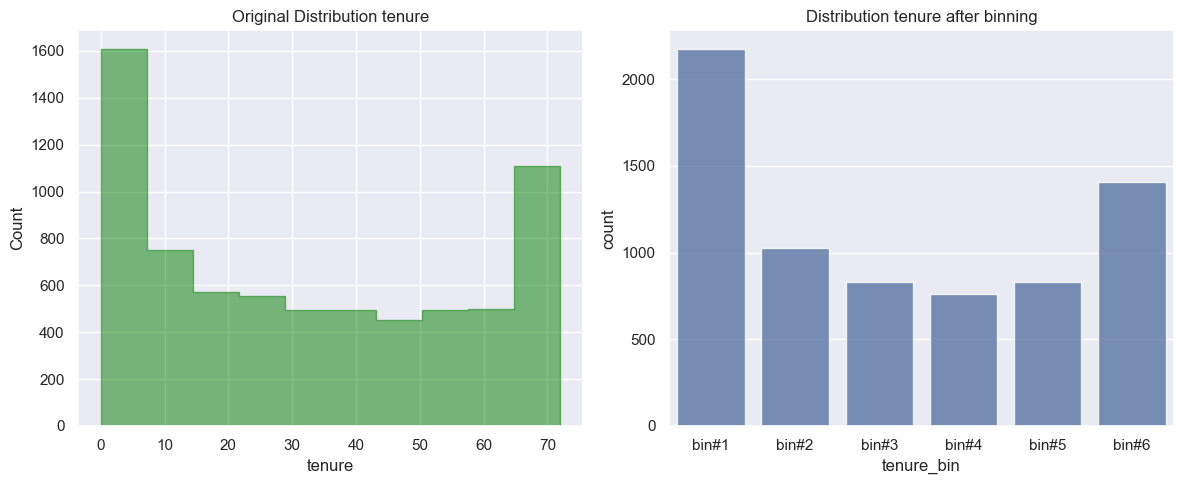

In [9]:
#Binning feature tenure in 6 parts
data_ml['tenure_bin'] = pd.cut(x=data_ml.tenure, bins=6, labels=['bin#1','bin#2','bin#3','bin#4','bin#5','bin#6'])

#Plot tenure and tenure after binning
fig,ax = plt.subplots(1,2,figsize=(12,5))

#Subplot 1: tenure
ax[0].hist(data_ml.tenure,histtype='step',fill=True,color='green',alpha=0.5)
ax[0].set_title('Original Distribution tenure')
ax[0].set_xlabel('tenure')
ax[0].set_ylabel('Count')

#Subplot 2: tenure after binning
sns.countplot(x=data_ml.tenure_bin,order=['bin#1','bin#2','bin#3','bin#4','bin#5','bin#6'],ax=ax[1],alpha=0.8)
ax[1].set_title('Distribution tenure after binning')

plt.tight_layout()

In [10]:
#Droping original feature tenure
data_ml = data_ml.drop(columns='tenure')

In [11]:
#Seperate data into categorical features and numerical features 
data_cat = data_ml.select_dtypes(include=['object','category']).copy()
data_num = data_ml.select_dtypes(include=['float64','int64']).copy()

## 2.3 One Hot Encoding

In [12]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

#instantiate and fit One Hot Encoder with categorical features
ohe = OneHotEncoder(drop='first', sparse_output=False)
data_cat_encoded = ohe.fit_transform(data_cat)

#Generate Dataframe with encoded categorical features
feature_names = ohe.get_feature_names_out(input_features=data_cat.columns)
data_cat_df = pd.DataFrame(data_cat_encoded, columns=feature_names, index=data_cat.index)

#Concat encoded categorical features with numerical features
data_trans = pd.concat([data_cat_df, data_num], axis=1)

## 2.4 Train Test Split

In [13]:
from sklearn.model_selection import train_test_split

#Train/Test Split
X = data_trans.drop(columns='Churn_Yes')
y = data_trans['Churn_Yes']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=123)

In [14]:
# Check Stratify
print('y_train',y_train.value_counts(normalize=True))
print('y_test',y_test.value_counts(normalize=True))

y_train Churn_Yes
0.0    0.735953
1.0    0.264047
Name: proportion, dtype: float64
y_test Churn_Yes
0.0    0.736131
1.0    0.263869
Name: proportion, dtype: float64


## 2.5 Scaling: Quantile Transforming

Quantile transformation of the features 'MonthlyCharges' and 'Total Charges'
.fit_transform of X_train and .transform of X_test to avoid data leakage

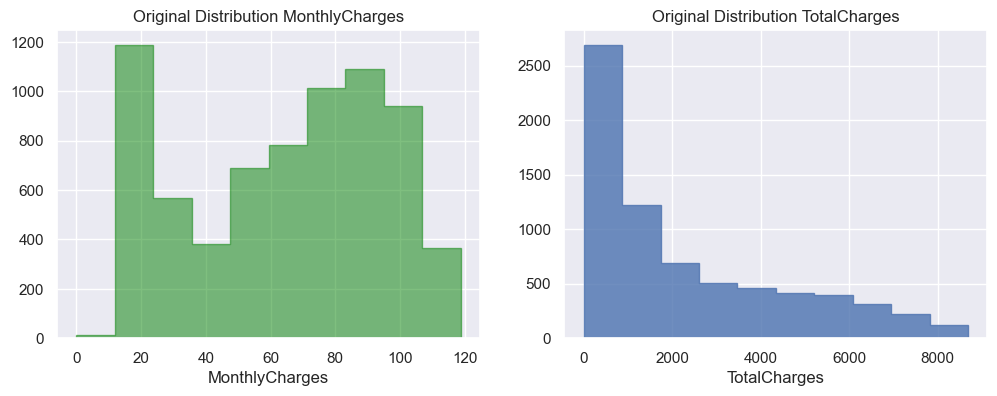

In [15]:
#Plot original distribution of Monthly and Total Charges

fig, ax = plt.subplots(1,2,figsize=(12,4))

#Subplot 1: Monthlycharges
data_ml.MonthlyCharges.hist(ax=ax[0],histtype='step',fill=True,color='green',alpha=0.5)
ax[0].set_title('Original Distribution MonthlyCharges')
ax[0].set_xlabel('MonthlyCharges')
ax[0].set_ylabel=('Count')

#Subplot 1: Totalcharges
data_ml.TotalCharges.hist(ax=ax[1],histtype='step',fill=True,alpha=0.8)
ax[1].set_title('Original Distribution TotalCharges')
ax[1].set_xlabel('TotalCharges')
ax[1].set_ylabel=('Count')

In [16]:
#Quantil Transforming
from sklearn.preprocessing import QuantileTransformer

#Instantiate Quantile Transformer
quantile_normal = QuantileTransformer(output_distribution='normal')

# Fit Transform X_train
X_train[['MonthlyCharges','TotalCharges']] = quantile_normal.fit_transform(X_train[['MonthlyCharges','TotalCharges']])

#Transform X_test
X_test[['MonthlyCharges','TotalCharges']] = quantile_normal.transform(X_test[['MonthlyCharges','TotalCharges']])

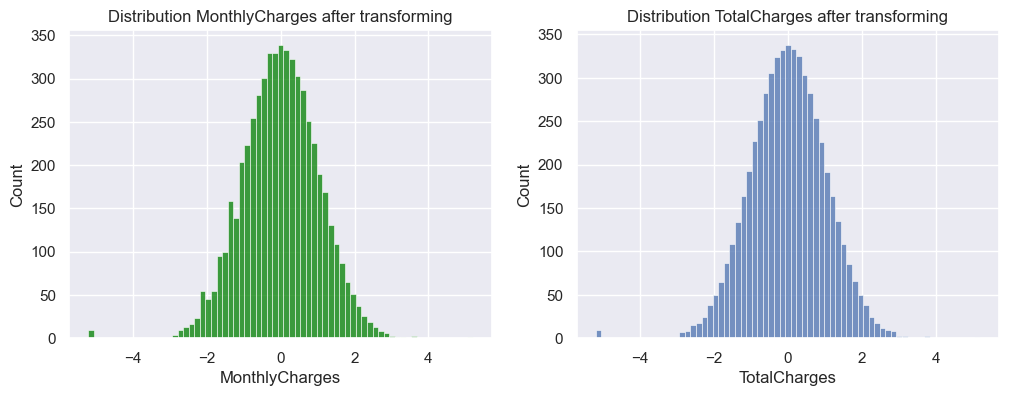

In [17]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

#Subplot 1: transformed MonthlyCharges
sns.histplot(X_train.MonthlyCharges,ax=ax[0],color='green')
ax[0].set_title('Distribution MonthlyCharges after transforming')
ax[0].set_xlabel('MonthlyCharges')
ax[0].set_ylabel=('Count')

#Subplot 1: transformed TotalCharges
sns.histplot(X_train.TotalCharges,ax=ax[1])
ax[1].set_title('Distribution TotalCharges after transforming')
ax[1].set_xlabel('TotalCharges')
ax[1].set_ylabel=('Count')


## 2.6 Class Balancing

In [18]:
#Original Distribution target 'Churn'
data_ml.Churn.value_counts(normalize=True)

Churn
No     0.735989
Yes    0.264011
Name: proportion, dtype: float64

In [19]:
#Oversampling/Undersampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE()
under = RandomUnderSampler()
steps = [('o',over),('u',under)]
pipeline = Pipeline(steps=steps)
X_train_bal, y_train_bal = pipeline.fit_resample(X_train,y_train)


#https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [20]:
y_train_bal.value_counts()

Churn_Yes
0.0    4139
1.0    4139
Name: count, dtype: int64

# 3 Training

In [22]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
from sklearn.model_selection import ValidationCurveDisplay

## 3.1 Metric

Goal is to keep as much as customers as possible. Therefore, recall would be the best metric for this. It answers the question, how good the model is in predicting customers which are truly churned.

Recall (True Positive Rate) = True Positive / true positive + false negative

## 3.2 Model 1: Logistic Regression

In [20]:
#Instantiate LogisticRegression
lr = LogisticRegression(solver='saga',max_iter=1000)

#Dictionary for hyperparameter tuning
lr_param_dict = {'penalty':['l1','l2'],'C':[0.001, 0.01, 0.1]}

#Instantiate GridsearchCV
gridcv_lr = GridSearchCV(estimator=lr,cv=5,param_grid=lr_param_dict,scoring='recall')

#Fit Gridsearch with balanced Classes
model_lr = gridcv_lr.fit(X_train_bal,y_train_bal)

#Best params
print(f'best params: {model_lr.best_params_}')

#Best score
print(f'best recall: {model_lr.best_score_} \n')

best params: {'C': 0.1, 'penalty': 'l1'}
best recall: 0.8209703894525934 



## 3.3 Model 2: K Nearest Neighbors

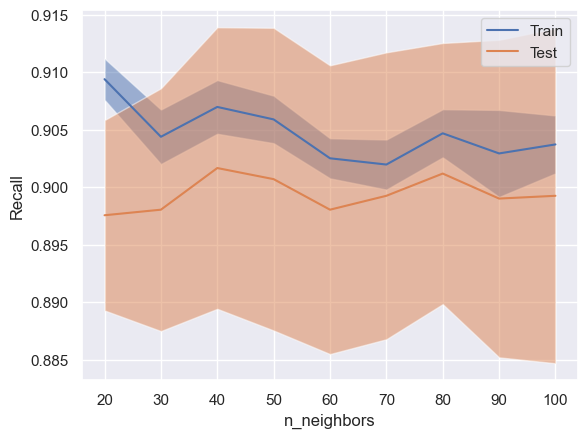

In [22]:
ValidationCurveDisplay.from_estimator(
   KNeighborsClassifier(), X_train_bal, y_train_bal,
       param_name="n_neighbors", param_range=[20,30,40,50,60,70,80,90,100],scoring='recall')

In [20]:
#Instantiate KNN
knn = KNeighborsClassifier()

#Dictionary for hyperparameter tuning
neighbors_range = range(60,100)
#knn_param_dict = {'n_neighbors':neighbors_range}

knn_param_dict = {
    'n_neighbors': neighbors_range,
    #'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan','hamming'],  
    #'leaf_size': [10, 20, 30],
}

#Instantiate GridsearchCV
gridcv_knn = GridSearchCV(estimator=knn,cv=5,param_grid=knn_param_dict,scoring='recall')

#Fit Gridsearch with training data
model_knn = gridcv_knn.fit(X_train_bal,y_train_bal)

#Best params
print(f'best params: {model_knn.best_params_}')

#Best score
print(f'best recall: {model_knn.best_score_} \n')

print(model_knn.cv_results_['mean_test_score'])

best params: {'metric': 'euclidean', 'n_neighbors': 91}
best recall: 0.9089141241551737 

[0.90166658 0.90577344 0.90335769 0.90625683 0.90456542 0.90698117
 0.90384049 0.90649808 0.90408175 0.90746368 0.90335652 0.90794706
 0.90432329 0.90698088 0.9038402  0.9060147  0.90335623 0.90698059
 0.90408116 0.90722155 0.90408087 0.90746339 0.90359807 0.90794677
 0.90504764 0.90698059 0.90456425 0.90794706 0.90553102 0.90818861
 0.90577257 0.90891412 0.9064975  0.90843103 0.90625595 0.90867229
 0.90625624 0.90867199 0.90504793 0.90746368 0.87943735 0.88523649
 0.8808875  0.88499553 0.88112934 0.8842706  0.87919668 0.88378751
 0.87992219 0.88451186 0.87968006 0.88282045 0.87774682 0.88137059
 0.87822991 0.88257861 0.87943793 0.88233794 0.87823049 0.88354567
 0.87943881 0.88354596 0.8794391  0.88282074 0.87967918 0.88354567
 0.88016257 0.8830617  0.87822991 0.88137117 0.87895542 0.88161272
 0.87919668 0.88233765 0.88064683 0.88306287 0.88064654 0.88378722
 0.88064624 0.88233794 0.81009849 0.817

## 3.4 Model 3: Support Vector Machines

In [22]:
#Instantiate Support Vector Classifier
svm = SVC(probability=True)

#Dictionary for hyperparameter tuning
svm_param_dict = {
    'C': [0.01,0.1], #0.001 removed
    'kernel': ['linear','rbf'], #poly removed to save runtime
    'gamma': ['scale', 'auto']} #0.1 and 0.001 removed

#Instantiate GridsearchCV
gridcv_svm = GridSearchCV(estimator=svm,cv=5,param_grid=svm_param_dict,scoring='recall')

#Fit Gridsearch with training data
model_svm = gridcv_svm.fit(X_train_bal,y_train_bal)

# Best params
print(f'best params: {model_svm.best_params_}')

#Best score
print(f'best recall: {model_svm.best_score_} \n')

print(gridcv_svm.cv_results_['mean_test_score'])

best params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
best recall: 0.8265285736817203 

[0.82024604 0.80309044 0.82024604 0.81782708 0.82652857 0.81661964
 0.82652857 0.81372255]


## 3.5 Model 4: Random Forest

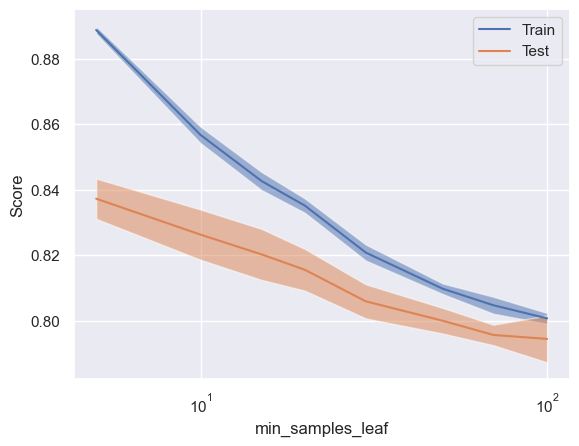

In [201]:
from sklearn.model_selection import ValidationCurveDisplay

ValidationCurveDisplay.from_estimator(
   RandomForestClassifier(
       random_state=123), X_train_bal, y_train_bal, 
       param_name="min_samples_leaf", param_range=[5,10,15,20,30,50,70,100])

In [23]:
#Instantiate Random Forest
rf = RandomForestClassifier(n_jobs=-1,random_state=123)

#Dictionary for hyperparameter tuning
rf_param_dict = {
    'max_depth': [15],
    'min_samples_leaf':[15,30,50,70],
    'max_features': ['sqrt',2,3,4,5] #mtry
}

#Instantiate GridsearchCV
gridcv_rf = GridSearchCV(estimator=rf,cv=5,param_grid=rf_param_dict,scoring='recall')

#Fit Gridsearch with training data
model_rf = gridcv_rf.fit(X_train_bal,y_train_bal)

# Best params
print(f'best params: {model_rf.best_params_}')

#Best score
print(f'best recall: {model_rf.best_score_} \n')


print(model_rf.cv_results_['mean_test_score'])

best params: {'max_depth': 15, 'max_features': 2, 'min_samples_leaf': 70}
best recall: 0.8342586264304366 

[0.83329127 0.81783029 0.81638073 0.81468932 0.8332939  0.8303936
 0.83232597 0.83425863 0.83015351 0.8255621  0.82435378 0.82435378
 0.82266472 0.81903831 0.81372314 0.8163816  0.83329127 0.81783029
 0.81638073 0.81468932]


# 4 Best Model

### 4.1 Training

In [21]:
best_model = KNeighborsClassifier(**model_knn.best_params_)

best_model.fit(X_train_bal,y_train_bal)

KNeighborsClassifier(metric='euclidean', n_neighbors=91)

### 4.2 Evaluation

In [22]:
#Test best model
y_pred_best = best_model.predict(X_test)
print('test:',recall_score(y_test,y_pred_best))

#Check overfitting
y_pred_best_train = best_model.predict(X_train)
print('train (overfitting):',recall_score(y_train,y_pred_best_train))

test: 0.8921832884097035
train (overfitting): 0.8976430976430977


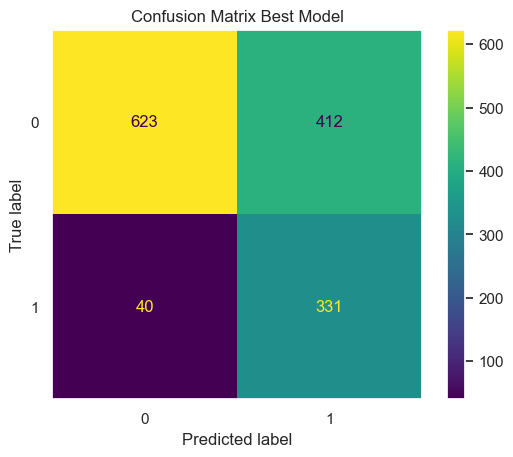

In [23]:
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix Best Model')
plt.grid()

In [24]:
print('accuracy_score:' ,accuracy_score(y_test,y_pred_best))
print('recall_score:', recall_score(y_test,y_pred_best))
print('precision_score:', precision_score(y_test,y_pred_best))
print('f1_score:', f1_score(y_test,y_pred_best))
print('roc_auc_score:', roc_auc_score(y_test,y_pred_best))

accuracy_score: 0.6785206258890469
recall_score: 0.8921832884097035
precision_score: 0.44549125168236875
f1_score: 0.5942549371633752
roc_auc_score: 0.7470578277797311


In [25]:
#Cross Validation Default Model
from sklearn.model_selection import cross_val_score

scores = cross_val_score(knn, X_train_bal, y_train_bal, cv=5,scoring='recall')
print('cross validation scores:',scores)

#Instantiating default model
knn_model_default = KNeighborsClassifier()

#Fitting default model
knn_model_default.fit(X_train_bal,y_train_bal)

#Test Default model default
y_pred_default = knn_model_default.predict(X_test)
print('test:',recall_score(y_test,y_pred_default))

#Check overfitting 
y_pred_default_train = knn_model_default.predict(X_train)
print('train (overfitting):',recall_score(y_train,y_pred_default_train))

cross validation scores: [0.91545894 0.92512077 0.9178744  0.91293833 0.92874396]
test: 0.7331536388140162
train (overfitting): 0.9387205387205387


In [26]:
y_pred_proba = best_model.predict_proba(X_test)

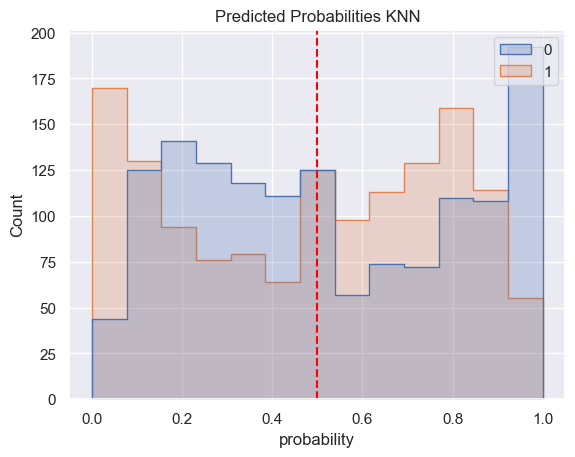

In [27]:
sns.histplot(y_pred_proba,element='step')
plt.xlabel('probability')
plt.title('Predicted Probabilities KNN')
plt.axvline(0.5,linestyle='--',color='red');

c:\Users\flori\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\flori\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


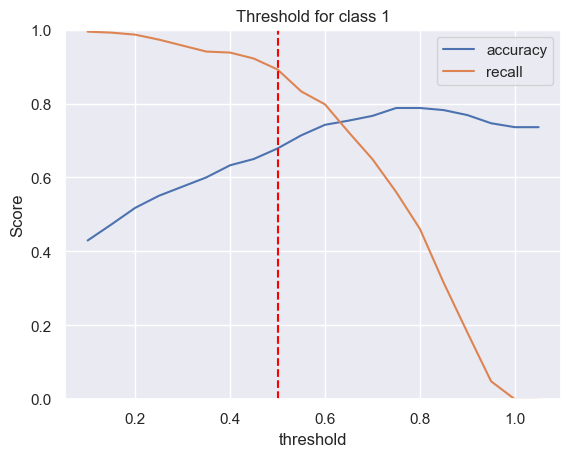

In [ ]:
threshold_range = np.arange(0.1,1.1,0.05)

accuracy_proba_test = []
recall_proba_test = []
precision_proba_test = []
f1_proba_test = []
roc_auc_proba_test = []

for threshold in threshold_range:
    y_test_pred = [1 if x >= threshold else 0 for x in y_pred_proba[:, 1]]

    accuracy_proba_test.append(accuracy_score(y_test, y_test_pred))
    recall_proba_test.append(recall_score(y_test, y_test_pred))
    precision_proba_test.append(precision_score(y_test, y_test_pred))
    f1_proba_test.append(f1_score(y_test, y_test_pred))
    roc_auc_proba_test.append(roc_auc_score(y_test, y_test_pred))


sns.lineplot(x=threshold_range,y=accuracy_proba_test,label='accuracy')
sns.lineplot(x=threshold_range,y=recall_proba_test,label='recall')
#sns.lineplot(x=threshold_range,y=precision_proba_test,label='precision')
#sns.lineplot(x=threshold_range,y=f1_proba_test,label='f1',color='y')
#sns.lineplot(x=threshold_range,y=roc_auc_proba_test,label='roc_auc',color='black')


plt.xlabel('threshold')
plt.ylabel('Score')
plt.title('Threshold for class 1')
plt.ylim(0,1);
plt.axvline(0.5,linestyle='--',color='red')
#plt.text(0.25,0.9,'Threshold 0.5',color='red');

In [29]:
roc_auc_threshold_df = pd.DataFrame({'Threshold':threshold_range,
                                     'Recall':recall_proba_test,
                                     'Accuracy':accuracy_proba_test,
                                     'Precison':precision_proba_test,
                                     'roc_auc':roc_auc_proba_test,})
roc_auc_threshold_df.sort_values(by='Threshold',ascending=False)

,Threshold,Recall,Accuracy,Precison,roc_auc
19,1.05,0.000000,0.736131,0.000000,0.500000
18,1.00,0.000000,0.736131,0.000000,0.500000
17,0.95,0.048518,0.746799,0.857143,0.522809
16,0.90,0.180593,0.768848,0.761364,0.580152
15,0.85,0.315364,0.782361,0.692308,0.632561
14,0.80,0.460916,0.788051,0.635688,0.683115
13,0.75,0.560647,0.788051,0.606414,0.715106
12,0.70,0.649596,0.766714,0.548975,0.729146
11,0.65,0.722372,0.753912,0.524462,0.743795
10,0.60,0.797844,0.742532,0.507719,0.760274


### 4.3 Feature Selection

In [30]:
sbs_best_model = SequentialFeatureSelector(estimator=model_knn.best_estimator_,
                                   forward=False,
                                   floating=False,
                                   scoring='recall',
                                   k_features=3)

sbs_best_model.fit(X_train_bal,y_train_bal)

SequentialFeatureSelector(estimator=KNeighborsClassifier(metric='euclidean',
                                                         n_neighbors=91),
                          forward=False, k_features=(3, 3), scoring='recall')

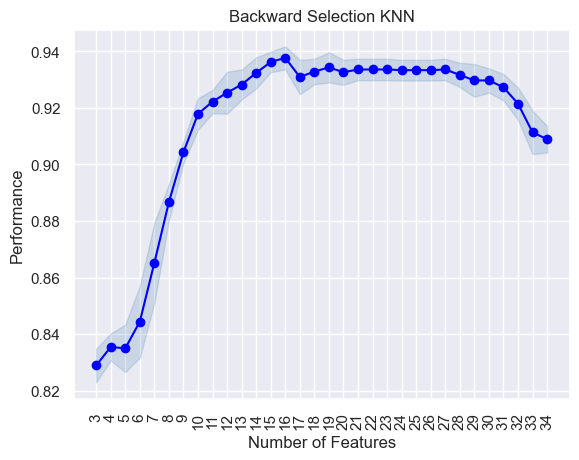

In [31]:
#Plot Performance
plot_sfs(sbs_best_model.get_metric_dict())
plt.title('Backward Selection KNN')
plt.xticks(rotation=90);

In [32]:
avg_score = [sbs_best_model.subsets_[i]['avg_score'] for i in range(3,35)]
n_features = [len(sbs_best_model.subsets_[i]['feature_names']) for i in range(3,35)]

sbs_performance_rf = pd.DataFrame({'n_features': n_features,
                                   'avg_recall': avg_score}) \
.sort_values(by='avg_recall',ascending=False) \
.reset_index(drop=True)

sbs_performance_rf[sbs_performance_rf['avg_recall'] > 0.90]

,n_features,avg_recall
0,16,0.937666
1,15,0.936216
2,19,0.934285
3,27,0.933560
4,21,0.933560
5,22,0.933560
6,23,0.933560
7,25,0.933319
8,24,0.933319
9,26,0.933319


In [35]:
print(sbs_best_model.subsets_[16]['cv_scores'])

[0.94444444 0.93236715 0.9384058  0.93833132 0.93478261]


In [36]:
sbs_best_model.subsets_[16]['feature_names']

('gender_Male',
 'Partner_Yes',
 'Dependents_Yes',
 'PhoneService_Yes',
 'MultipleLines_Yes',
 'InternetService_No',
 'StreamingTV_Yes',
 'StreamingMovies_Yes',
 'Contract_One year',
 'Contract_Two year',
 'PaymentMethod_Credit card (automatic)',
 'tenure_bin_bin#2',
 'tenure_bin_bin#3',
 'tenure_bin_bin#5',
 'tenure_bin_bin#6',
 'MonthlyCharges')

In [21]:
import tensorflow as tf
import keras
from keras import layers

In [32]:
model = tf.keras.Sequential(
    [
    layers.Dense(17,input_shape=(34,),activation = 'relu'),
    layers.Dense(9,activation = 'relu'),
    layers.Dense(1,activation='sigmoid')
    ]
    )

c:\Users\flori\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 17)             │           595 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 9)              │           162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 767 (3.00 KB)

 Trainable params: 767 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
model.compile(loss='binary_crossentropy',metrics=['recall'],optimizer='sgd')

In [45]:
model.fit(X_train_bal,y_train_bal,epochs=100)

Epoch 1/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3400 - recall: 0.8886
Epoch 2/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3404 - recall: 0.8901
Epoch 3/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3375 - recall: 0.8905  
Epoch 4/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3394 - recall: 0.8866
Epoch 5/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3372 - recall: 0.8858
Epoch 6/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3431 - recall: 0.8918
Epoch 7/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3400 - recall: 0.8853
Epoch 8/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3290 - recall: 0.8830
Epoch 9/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3263 - recall: 0.8886
Epoch 10/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3306 - recall: 0.8947
Epoch 11/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3388 - recall: 0.8824
Epoch 12/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: